# Predicting period and mass ratio of hot subdwarfs

The aim of this tutorial is to show how NNaPS can be used to predict the orbital parameters of hot subdwarf binaries based on a relatively small sample of full MESA models. 

We will use a sample of ~2000 binary MESA models focused on low mass binaries that interact on the red giant branch. We will train a fully connected model to predict if the interaction phase is stable, the orbital parameters (period and mass ratio) after the mass-loss phase and the final product (hot subdwarf, horizontal branch star or He white dwarf) after the mass-loss phase.

Then we will check how different metalicity distributions in the intial population will affect those final orbital parameters. 

In [1]:
import pandas as pd
import pylab as pl
import seaborn as sns

import yaml
from nnaps import predictors

Using TensorFlow backend.


## Obtaining the data

Let's download the extracted MESA models:

In [2]:
data = pd.read_csv('http://www.astro.physik.uni-potsdam.de/~jorisvos/nnaps/period_mass_ratio_mesa_models_extracted.csv')

In [3]:
data

,M1_init,M2_init,q_init,P_init,FeH_init,stability,product,P_final,q_final
0,1.791000,1.138,1.573813,3.570104,-0.109671,stable,He-WD,52.924494,0.265416
1,0.954000,0.355,2.687324,410.120037,-0.780000,unstable,UK,0.618103,1.245376
2,1.297000,0.865,1.499421,371.590147,-0.218502,stable,sdB,1130.865820,0.541258
3,1.554999,0.579,2.685664,61.920032,-0.282191,unstable,UK,0.045363,0.560722
4,1.291999,0.378,3.417988,23.240011,-0.493334,unstable,UK,0.005948,0.740944
...,...,...,...,...,...,...,...,...,...
2340,0.922000,0.657,1.403348,139.840010,-0.780000,stable,He-WD,326.953825,0.623666
2341,1.496000,1.323,1.130763,138.060030,-0.840593,stable,HB,753.134322,0.402106
2342,1.154000,0.410,2.814634,311.360022,0.182481,unstable,UK,0.187493,0.932706
2343,0.771000,0.714,1.079832,231.110008,-1.292690,stable,He-WD,438.852463,0.658157


The features that we are interested in are the inital parameters of the models:
- M1_init: initial mass of the donor star
- q_init: initial mass ratio
- P_init: initial orbital period
- FeH_init: metalicity

The properties that we want to predict are:
- stability: if the mass loss phase is stable or not
- product: what type of star we get after the mass loss phase (sdB, HB, He-WD or UK for systems that are unstable)
- P_final: orbital period after interaction phase
- q_final: mass ratio after the interaction phase

In [5]:
features = ['M1_init', 'q_init', 'P_init', 'FeH_init']
classifiers = ['stability', 'product']
regressors = ['P_final', 'q_final']

## Data analysis

Let's start with having a look at the data we are working with.

In [ ]:
stable = data[data['stability'] == 'stable']

In [6]:
data['stability'].value_counts()

stable      1586
unstable     759
Name: stability, dtype: int64

In [7]:
data['product'].value_counts()

He-WD    853
UK       759
HB       421
sdB      312
Name: product, dtype: int64

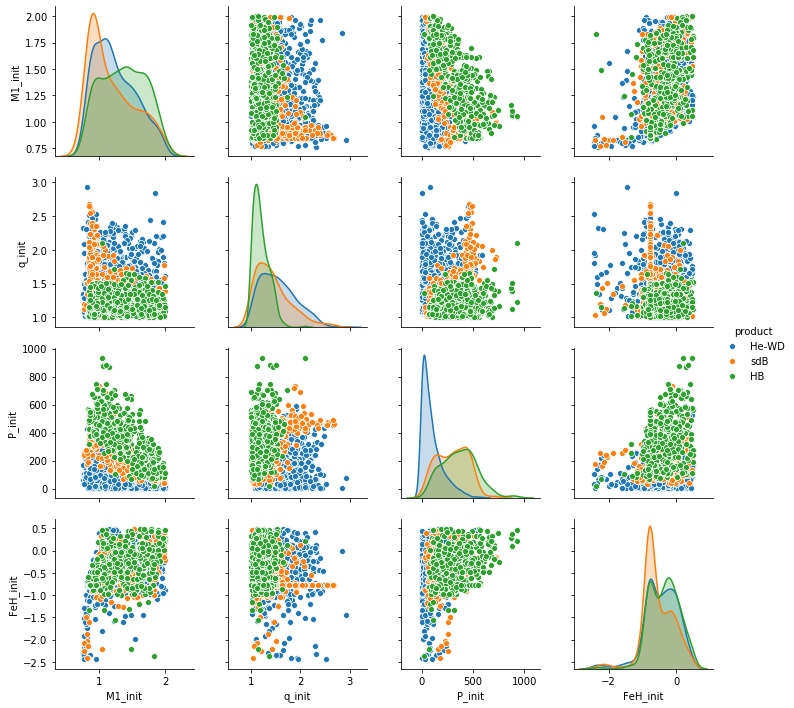

In [8]:
sns.pairplot(stable, vars=features, hue='product')

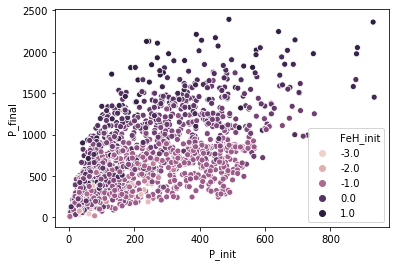

In [9]:
sns.scatterplot('P_init', 'P_final', data=stable, hue='FeH_init')

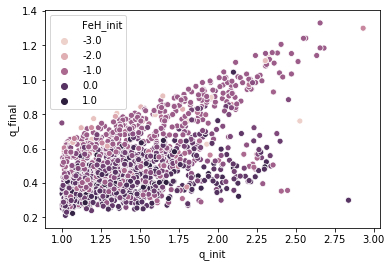

In [10]:
sns.scatterplot('q_init', 'q_final', data=stable, hue='FeH_init')

## Modeling

Now we can make a predictive model. We will use a fully connected shallow neural network with 3 layers. Important to notice is that the features are automatically scaled, but since we are working with two targets (P_final and q_final) that are very different in range, we need to apply a scaler to these variables to avoid one of them dominating the loss function.

In [11]:
setup = """
features: 
    - M1_init
    - q_init
    - P_init
    - FeH_init
regressors:
    P_final:
        processor: StandardScaler
    q_final:
        processor: StandardScaler
classifiers: 
    - stability
    - product
model:
   - {'layer':'Dense',   'args':[200], 'kwargs': {'activation':'relu', 'name':'FC_1'} }
   - {'layer':'Dense',   'args':[100], 'kwargs': {'activation':'relu', 'name':'FC_2'} }
   - {'layer':'Dense',   'args':[50],  'kwargs': {'activation':'relu', 'name':'FC_3'} }
optimizer: adam
"""
setup = yaml.safe_load(setup)

In [12]:
predictor = predictors.FCPredictor(setup=setup, data=data)

In [13]:
predictor.fit(epochs=100, batch_size=124, reduce_lr=True)

Train on 1876 samples, validate on 469 samples
Epoch 1/100
 - 1s - loss: 3.3076 - P_final_loss: 0.5563 - q_final_loss: 0.7013 - stability_loss: 0.6195 - product_loss: 1.3635 - P_final_mae: 0.6184 - q_final_mae: 0.3683 - stability_accuracy: 0.7777 - product_accuracy: 0.3241 - val_loss: 2.2777 - val_P_final_loss: 0.3099 - val_q_final_loss: 0.1414 - val_stability_loss: 0.5188 - val_product_loss: 1.3055 - val_P_final_mae: 0.4181 - val_q_final_mae: 0.2271 - val_stability_accuracy: 0.8380 - val_product_accuracy: 0.3198
Epoch 2/100
 - 0s - loss: 2.3581 - P_final_loss: 0.2519 - q_final_loss: 0.4045 - stability_loss: 0.4448 - product_loss: 1.2132 - P_final_mae: 0.3392 - q_final_mae: 0.2182 - stability_accuracy: 0.8417 - product_accuracy: 0.4488 - val_loss: 1.7413 - val_P_final_loss: 0.2005 - val_q_final_loss: 0.0971 - val_stability_loss: 0.3377 - val_product_loss: 1.1101 - val_P_final_mae: 0.3216 - val_q_final_mae: 0.1601 - val_stability_accuracy: 0.8721 - val_product_accuracy: 0.6141
Epoch 3/1

Epoch 19/100
 - 0s - loss: 0.7957 - P_final_loss: 0.0532 - q_final_loss: 0.3301 - stability_loss: 0.1156 - product_loss: 0.2775 - P_final_mae: 0.1597 - q_final_mae: 0.2370 - stability_accuracy: 0.9435 - product_accuracy: 0.8993 - val_loss: 0.4659 - val_P_final_loss: 0.0459 - val_q_final_loss: 0.0833 - val_stability_loss: 0.0910 - val_product_loss: 0.2492 - val_P_final_mae: 0.1502 - val_q_final_mae: 0.1570 - val_stability_accuracy: 0.9701 - val_product_accuracy: 0.9126
Epoch 20/100
 - 0s - loss: 0.6928 - P_final_loss: 0.0476 - q_final_loss: 0.2491 - stability_loss: 0.1146 - product_loss: 0.2650 - P_final_mae: 0.1527 - q_final_mae: 0.1499 - stability_accuracy: 0.9483 - product_accuracy: 0.9019 - val_loss: 0.4797 - val_P_final_loss: 0.0477 - val_q_final_loss: 0.1085 - val_stability_loss: 0.0889 - val_product_loss: 0.2406 - val_P_final_mae: 0.1407 - val_q_final_mae: 0.1524 - val_stability_accuracy: 0.9659 - val_product_accuracy: 0.9147
Epoch 21/100
 - 0s - loss: 0.6860 - P_final_loss: 0.04

Epoch 37/100
 - 0s - loss: 0.6091 - P_final_loss: 0.0375 - q_final_loss: 0.2183 - stability_loss: 0.1217 - product_loss: 0.2411 - P_final_mae: 0.1239 - q_final_mae: 0.1111 - stability_accuracy: 0.9494 - product_accuracy: 0.9120 - val_loss: 0.4389 - val_P_final_loss: 0.0382 - val_q_final_loss: 0.1046 - val_stability_loss: 0.0866 - val_product_loss: 0.2155 - val_P_final_mae: 0.1209 - val_q_final_mae: 0.1207 - val_stability_accuracy: 0.9701 - val_product_accuracy: 0.9211
Epoch 38/100
 - 0s - loss: 0.6102 - P_final_loss: 0.0363 - q_final_loss: 0.2194 - stability_loss: 0.1047 - product_loss: 0.2241 - P_final_mae: 0.1234 - q_final_mae: 0.1131 - stability_accuracy: 0.9504 - product_accuracy: 0.9142 - val_loss: 0.4444 - val_P_final_loss: 0.0379 - val_q_final_loss: 0.1080 - val_stability_loss: 0.0884 - val_product_loss: 0.2161 - val_P_final_mae: 0.1233 - val_q_final_mae: 0.1191 - val_stability_accuracy: 0.9680 - val_product_accuracy: 0.9211

Epoch 00038: ReduceLROnPlateau reducing learning rate


Epoch 00053: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 00053: early stopping
Training results
target           mean  training score   test score
--------------------------------------------------
P_final     :  444.678       60.521       59.283
q_final     :    0.661        0.067        0.071
stability   :  -        95.1%        96.8%
product     :  -        91.5%        92.3%


We can now have a look at how the model trained, what the final accuracy and mean absolute errors are for the targets:

Training results
target           mean  training score   test score
--------------------------------------------------
P_final     :  444.678       60.521       59.283
q_final     :    0.661        0.067        0.071
stability   :  -        95.1%        96.8%
product     :  -        91.5%        92.3%


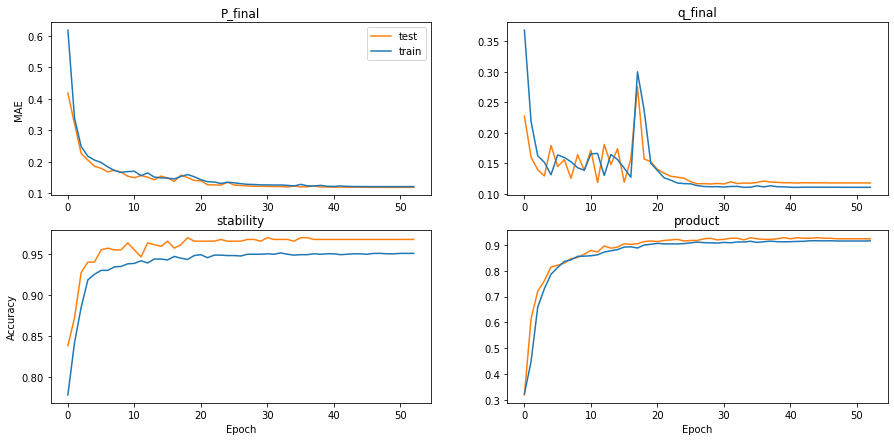

In [14]:
pl.figure(figsize=(15,7))
predictor.print_score()
predictor.plot_training_history()

For the classifiers we can also plot a confusion matrix:

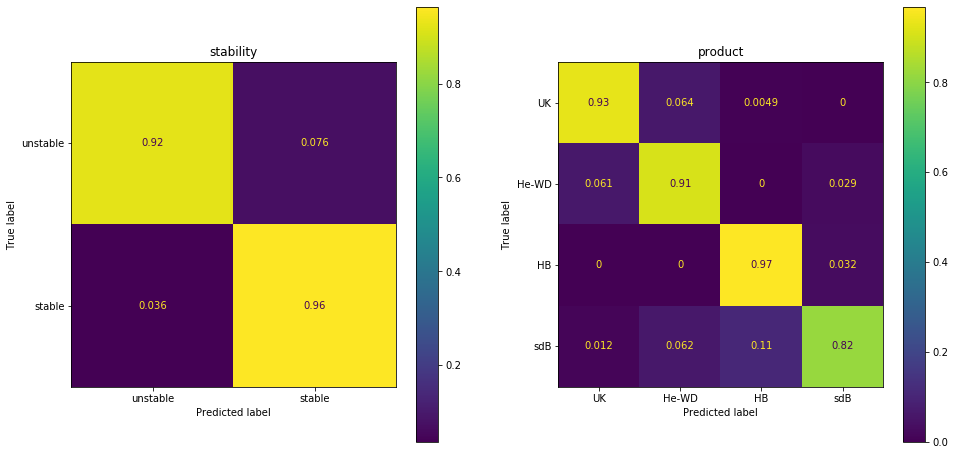

In [15]:
pl.figure(figsize=(16, 8))
predictor.plot_confusion_matrix()

## Making predictions

Download four samples with different metalicity distributions

In [16]:
sample_m1 = pd.read_csv('http://www.astro.physik.uni-potsdam.de/~jorisvos/nnaps/Sample_FeH_m1.csv')
sample_solar = pd.read_csv('http://www.astro.physik.uni-potsdam.de/~jorisvos/nnaps/Sample_FeH_solar.csv')
sample_uniform = pd.read_csv('http://www.astro.physik.uni-potsdam.de/~jorisvos/nnaps/Sample_FeH_uniform.csv')
sample_besancon = pd.read_csv('http://www.astro.physik.uni-potsdam.de/~jorisvos/nnaps/Sample_FeH_besancon.csv')

In [17]:
observations = pd.read_csv('http://www.astro.physik.uni-potsdam.de/~jorisvos/nnaps/observations_p_q.csv')

In [18]:
pred_m1 = predictor.predict(sample_m1)
pred_solar = predictor.predict(sample_solar)
pred_uniform = predictor.predict(sample_uniform)
pred_besancon = predictor.predict(sample_besancon)

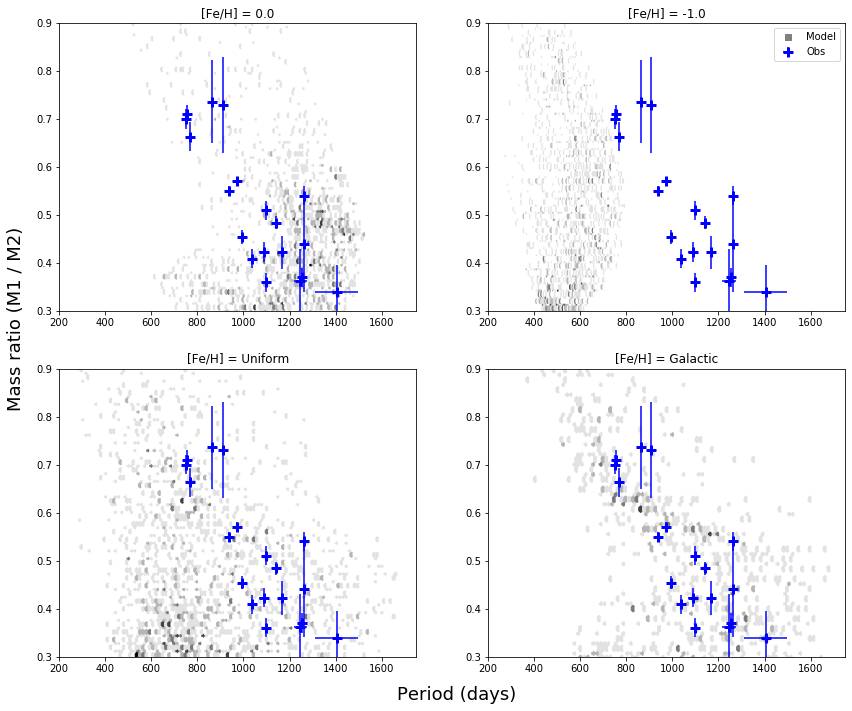

In [19]:
def plot_set(data, ax):
    ax.set_facecolor('w')
    s = data[(data['product'] == 'sdB')]
    x, y = s['P_final'], s['q_final']
    hb = ax.hexbin(x, y, gridsize=100, cmap='Greys', vmax=5)
    
    pl.errorbar(observations['P'], observations['q'], xerr=observations['P_e'], yerr=observations['q_e'], 
                marker='+', color='b', ls='', ms=10, mew=3, label='Obs')
    
    pl.xlim([200,1750])
    pl.ylim([0.3, 0.9])
  

pl.figure(1, figsize=(12, 10))
pl.subplots_adjust(left=0.07, right=0.98, bottom=0.07, top=0.95)

ax = pl.subplot(221)
plot_set(pred_solar, ax)
pl.title('[Fe/H] = 0.0')

ax = pl.subplot(222)
plot_set(pred_m1, ax)
pl.title('[Fe/H] = -1.0')
pl.plot([0], [0], 's', color='gray', label='Model')
pl.legend()

ax = pl.subplot(223)
plot_set(pred_uniform, ax)
pl.title('[Fe/H] = Uniform')

ax = pl.subplot(224)
plot_set(pred_besancon, ax)
pl.title('[Fe/H] = Galactic')

_ = pl.figtext(0.53, 0.01, 'Period (days)', ha='center', size=18)
_ = pl.figtext(0.01, 0.54, 'Mass ratio (M1 / M2)', va='center', size=18, rotation='vertical')